### Fitting the Mason dataset
This simple notebook (which needs a little cleanup and refactoring, TODO) illustrates a simple mixture
of categorical distributions as fitted to the Mason dataset. This one is especially easy to fit using
a categorical mixture model since only ten amino acids are involved.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from antpack import SingleChainAnnotator
from sklearn.metrics import roc_auc_score, average_precision_score
from categorical_mix import CategoricalMixture as Catmix

if "notebooks" in os.getcwd():
    os.chdir("..")
    home_dir = os.getcwd()

os.chdir(home_dir)

from antibody_scoring.data_prep.data_processing import preprocess_mason
from antibody_scoring.constants import seq_encoding_constants as SEC
from antibody_scoring.evaluations.mason_evals import get_tt_split
from antibody_scoring.evaluations.shared_eval_funcs import build_cat_model
from antibody_scoring.data_prep.seq_encoder_functions import IntegerEncoder

/ssd1/Documents/Wang_Lab_Projects/COVID/venv_supplementary/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
aligned_seqs, yvalues = preprocess_mason(home_dir)
xvalues = IntegerEncoder().encode(aligned_seqs)
trainx, trainy, testx, testy = get_tt_split(xvalues, yvalues, 123)

We fit a separate mixture model to both the negatives and positives.

In [3]:
trainx_positives = trainx[trainy==1,...]
pos_model = build_cat_model(trainx_positives, num_possible_items=20)

Loss: -34.08485697944889
Loss: -17.92018226412599
Loss: -17.92018226412599
Iterations: 2****************

Loss: -33.417471870379934
Loss: -17.92018226412599
Loss: -17.92018226412599
Iterations: 2****************

Loss: -31.43491498594572
Loss: -17.92018226412599
Loss: -17.92018226412599
Iterations: 2****************

Loss: -33.25105388949271
Loss: -17.92018226412599
Loss: -17.92018226412599
Iterations: 2****************

Loss: -30.672913898930478
Loss: -17.92018226412599
Loss: -17.92018226412599
Iterations: 2****************

Loss: -31.574828679799577
Loss: -17.921115146194566
Loss: -17.88505420543822
Loss: -17.851228694748144
Loss: -17.802408500575755
Loss: -17.741329292884092
Loss: -17.67804946521664
Loss: -17.62544562007686
Loss: -17.59322339109302
Loss: -17.57800601898924
Loss: -17.571892972228035
Loss: -17.569245177692473
Loss: -17.568223429853546
Loss: -17.567900646406827
Iterations: 13****************

Loss: -32.38426448158915
Loss: -17.953673760349343
Loss: -17.916403039887214


In [4]:
trainx_negatives = trainx[trainy==0,...]
neg_model = build_cat_model(trainx_negatives, num_possible_items=20)

Loss: -34.286005775520735
Loss: -20.59565126282314
Loss: -20.59565126282314
Iterations: 2****************

Loss: -33.71677215627513
Loss: -20.59565126282314
Loss: -20.59565126282314
Iterations: 2****************

Loss: -31.848174662483686
Loss: -20.59565126282314
Loss: -20.59565126282314
Iterations: 2****************

Loss: -34.077725092553266
Loss: -20.59565126282314
Loss: -20.59565126282314
Iterations: 2****************

Loss: -31.968332229362773
Loss: -20.59565126282314
Loss: -20.59565126282314
Iterations: 2****************

Loss: -32.16114782206393
Loss: -20.580792969016542
Loss: -20.465653886557387
Loss: -20.27728668298373
Loss: -20.109130273469187
Loss: -20.037215633187554
Loss: -20.010423132633747
Loss: -19.998868800363024
Loss: -19.99424596578855
Loss: -19.99268117621343
Loss: -19.99220008117825
Iterations: 10****************

Loss: -32.61473463688304
Loss: -20.63729329126294
Loss: -20.601918623220683
Loss: -20.588830176972
Loss: -20.571113392366854
Loss: -20.520174481822686
Lo

In [5]:
test_scores = pos_model.score(testx)

To use this as a classifier, we would use both the positive and negative models, and this is the procedure used
in the scripted experiments. It's interesting however that merely using scores from the positive model alone
is in this instance sufficient to distinguish positives from negatives.

0.8636689947756493


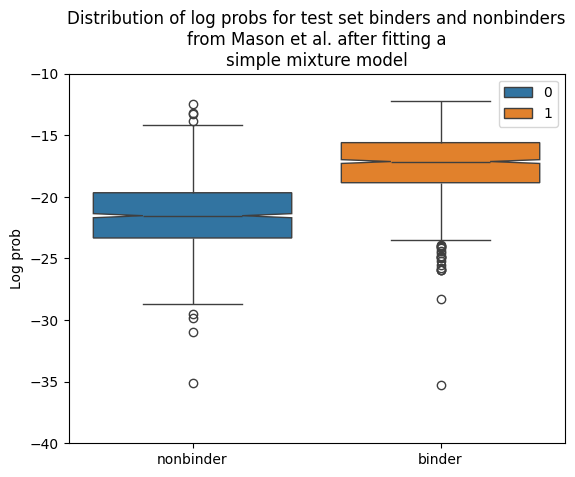

In [6]:
sns.boxplot(x=testy, hue=testy, y=test_scores, notch=True)
plt.ylim(-40,-10)
plt.title("Distribution of log probs for test set binders and nonbinders\nfrom Mason et al. after fitting a\nsimple mixture model")
plt.ylabel("Log prob")
plt.xticks([0,1], ["nonbinder", "binder"])
print(roc_auc_score(testy, test_scores))

We now compare and contrast the distribution of the clusters identified by each model for positives and negatives
in the training set.

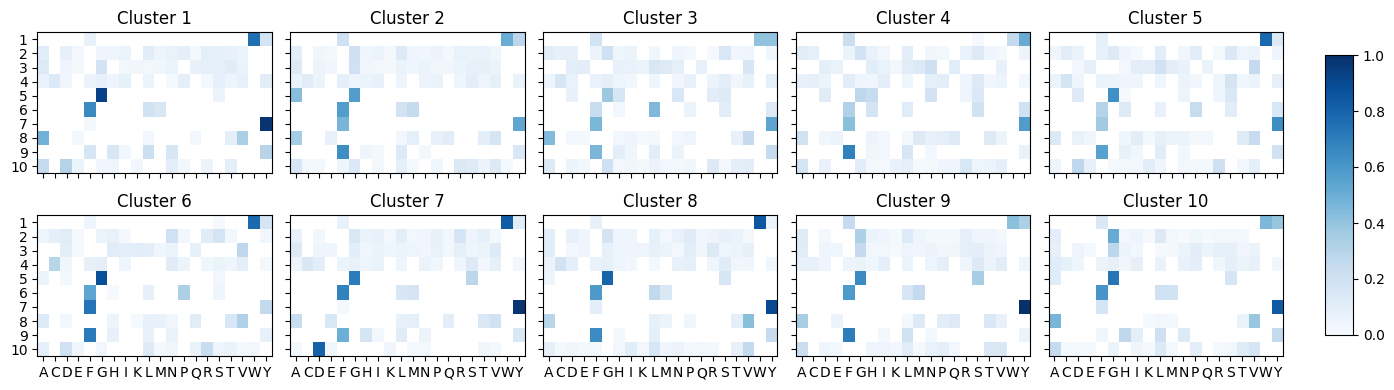

In [7]:
fig, axes = plt.subplots(2,5, figsize=(14,4), sharex=True, sharey=True)
axes = [a for al in axes for a in al]

for i, ax in enumerate(axes):
    flat_mat = pos_model.mu_mix[i,...].copy()
    flat_mat[flat_mat<1e-2] = np.nan
    im = ax.imshow(flat_mat, aspect="auto", vmin=0, vmax=1, cmap="Blues")
    ax.set_title(f"Cluster {i+1}")
    if i > 5:
        ax.set_xticks(np.arange(20), SEC.aas[:-1])
    if i % 5 == 0:
        ax.set_yticks(np.arange(10), np.arange(10) + 1)

plt.tight_layout()

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

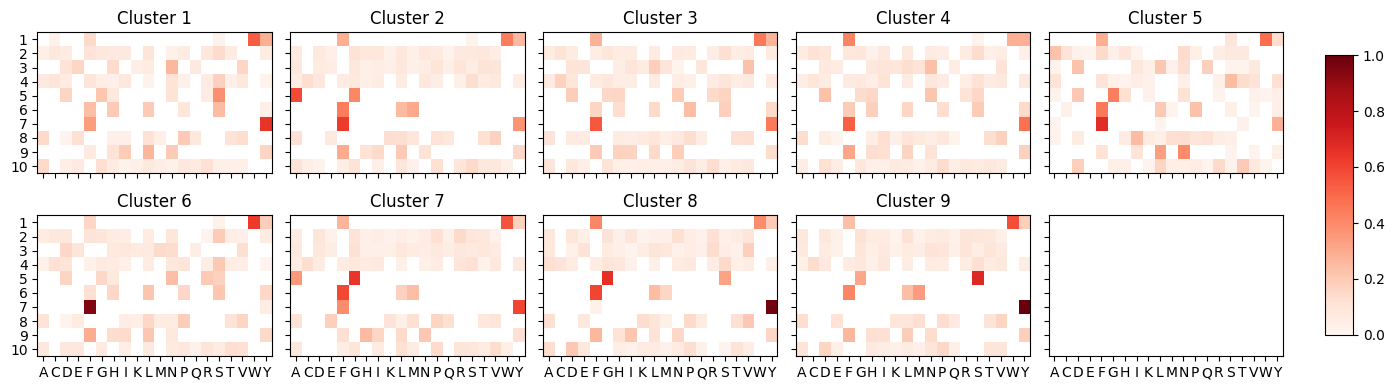

In [8]:
fig, axes = plt.subplots(2,5, figsize=(14,4), sharex=True, sharey=True)
axes = [a for al in axes for a in al]

for i, ax in enumerate(axes[:9]):
    flat_mat = neg_model.mu_mix[i,...].copy()
    flat_mat[flat_mat<1e-2] = np.nan
    im = ax.imshow(flat_mat, aspect="auto", vmin=0, vmax=1, cmap="Reds")
    ax.set_title(f"Cluster {i+1}")
    if i > 5:
        ax.set_xticks(np.arange(20), SEC.aas[:-1])
    if i % 5 == 0:
        ax.set_yticks(np.arange(10), np.arange(10) + 1)

plt.tight_layout()

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()